In [126]:
# pip install geopandas rasterio geopy 

import glob
from datetime import datetime
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc

import rasterio
from rasterio.transform import from_bounds
from rasterio.crs import CRS
import geopandas as gpd
import cartopy.crs as ccrs
from geopy.distance import geodesic
from shapely.geometry import Polygon



In [2]:
from FFP_Python import calc_footprint_FFP as fp
from FFP_Python import calc_footprint_FFP_climatology as fpc

## Footprints

In [3]:
# Считывает csv-файлы по шаблону и объединяет их в один DataFrame
def create_df(file_pattern, sep=';'):
    
    file_list = glob.glob(file_pattern)
    file_list = sorted(file_list)

    combined_df = pd.DataFrame()
    for file_name in file_list:
        df = pd.read_csv(file_name, sep=sep)
        combined_df = pd.concat([combined_df, df], ignore_index=True)

    return combined_df
    
# позволяет получить координату новой точки, лежащей в скольких-то метрах от стартовой 
def new_point(lat, lon, delta_lat, delta_lon, xy=False):
    # (lat, lon) - Координаты точки (широта, долгота) в градусах
    # (delta_lat, delta_lon) - Cмещение точки по (широте, долготе) в метрах

    # Рассчитываем координаты точки смещения по широте
    new_lat = lat + (delta_lat / geodesic((lat, lon), (lat + 1, lon)).meters)

    # Рассчитываем координаты точки смещения по долготе
    new_lon = lon + (delta_lon / geodesic((lat, lon), (lat, lon + 1)).meters)
    
    if xy:
        return (new_lon, new_lat)
    else:
        return (new_lat, new_lon)


def calculate_coriolis_parameter(latitude):
    omega = 7.2921e-5 # угловая скорость вращения Земли  рад/сек
    f = 2 * omega * np.sin(np.radians(latitude))
    return f


def select_variables_for_fp_calculation(df):
    datetime = pd.to_datetime(df['date'] + ' ' + df['time'])

    df = df[['wind_speed', 'wind_dir','(z-d)/L', 
         'L', 'u*', 'u_var', 'v_var']].astype(float)
    
    df.index = datetime
    df['datetime'] = datetime


    # f = calculate_coriolis_parameter(60.89142435)
    # df['h'] = (-1 + (1 + 2.28 * df['u*'] / (df['L'] * f)) ** (1/2)) * df['L'] / 3.8
    # df.loc[df['(z-d)/L']<0,'h'] = 1000
    # df['sigmav'] = (df['u_var']+df['v_var'])**(1/2)

    # df = df[df['u*']>0.1]
    
    df.dropna(inplace=True)
    return df

In [231]:
name = 'bek_30m'
input_files = './input/bek/30/*.csv'
output_path = './output/bek/30/'
tower_lat = 56.4808722197168
tower_lon = 85.1015260601068
tower_h = 30

# name = 'imces_bdmk_30m'
# input_files = './input/imces/bdmk/30/*.csv'
# output_path = './output/imces/bdmk/30/'
# tower_lat = 56.4749440905583
# tower_lon = 85.0543485585687
# tower_h = 30

# name = 'imces_bdmk_40m'
# input_files = './input/imces/bdmk/40/*.csv'
# output_path = './output/imces/bdmk/40/'
# tower_lat = 56.4749440905583
# tower_lon = 85.0543485585687
# tower_h = 40

# name = 'imces_mezo_30m'
# input_files = './input/imces/mezo/30/*.csv'
# output_path = './output/imces/mezo/30/'
# tower_lat = 56.4757084256941
# tower_lon = 85.054697213036
# tower_h = 30

# name = 'oblcom_30m'
# input_files = './input/oblcom/30/*.csv'
# output_path = './output/oblcom/30/'
# tower_lat = 56.4671832881314
# tower_lon = 84.9574514166707
# tower_h = 30


df = create_df(input_files)
# print(*df.columns, sep='\n')

df['data'] = pd.to_datetime(df.data, dayfirst=True)
df['wu_h'] = (df.uw**2 + df.vw**2) ** 0.5
# # f = calculate_coriolis_parameter(tower_lat)
# # df['h_abl'] = (-1 + (1 + 2.28 * df.u_star / (df.L * f)) ** (1/2)) * df.L / 3.8
# # df.loc[tower_h/df.L<0,'h_abl'] = 1000
# df['h_abl'] = 1000
# df['std_u'] = df.uu**(0.5)

# df = df[['data','Vvec','D','std_u','u_star','L', 'h_abl']]
# df = df[df['u_star'] > 0.1]
# # df = df[df['L'] >= -tower_h/15.5]

# df['z'] = tower_h
df

,N,data,uv,uw,vw,wt,ut,vt,uu,vv,...,rmsVs,rmsVe,wcor,alfa,pt,pu,pv,pw,rmsp,wu_h
0,0,2024-10-17 15:40:00,-0.033692,0.039542,0.082843,0.021481,0.052587,-0.002702,0.649351,0.649351,...,0.589179,0.713479,-0.001943,-1.673495,1.392433e-09,1.185178e-09,-9.503555e-09,-1.026215e-10,0.016587,0.091796
1,1,2024-10-17 16:00:00,-0.154231,0.126735,-0.023227,0.019643,0.018226,-0.004726,1.034299,1.034299,...,0.903174,0.799729,-0.002163,-0.398070,-1.660108e-08,-2.642261e-07,-1.110448e-07,3.317124e-08,13.860778,0.128846
2,2,2024-10-17 16:20:00,-0.508734,0.107029,-0.011918,0.008556,0.041601,-0.011689,1.544628,1.544628,...,0.449274,0.966529,-0.005786,-0.332555,1.951503e-08,-6.570123e-08,-1.814278e-07,7.805043e-08,0.053889,0.107691
3,3,2024-10-17 16:40:00,-0.164027,0.047355,0.000952,0.002082,0.019815,-0.003684,0.673934,0.673934,...,0.690540,0.691455,0.001193,-0.340172,-1.605423e-09,2.331528e-09,9.523958e-08,3.775077e-08,6.947786,0.047365
4,4,2024-10-17 17:00:00,0.027950,0.085868,0.009425,0.001136,0.019845,0.013952,0.584569,0.584569,...,0.599703,0.778204,-0.002077,2.231352,-3.724830e-11,7.032716e-10,1.122982e-09,1.735949e-10,6.943587,0.086383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2686,1794,2024-11-26 08:20:00,-0.100884,-0.024506,0.030575,-0.010328,0.032689,-0.004898,0.965224,0.965224,...,1.037394,0.570155,0.009284,-5.735067,-1.267641e-08,-2.991050e-08,2.050346e-08,-4.482321e-08,0.118001,0.039184
2687,1795,2024-11-26 08:40:00,-0.077922,-0.006723,0.004821,-0.005476,0.009864,-0.005974,0.247229,0.247229,...,0.454951,0.393266,0.012264,-5.438945,2.455270e-10,8.779008e-10,-5.124464e-10,-4.586412e-10,9.893051,0.008273
2688,1796,2024-11-26 09:00:00,-0.062181,-0.005193,0.011216,-0.005590,0.013779,-0.028314,0.160557,0.160557,...,0.410944,0.367303,0.008866,-5.673716,2.066992e-09,1.576748e-08,-4.468762e-09,-1.022083e-08,6.989137,0.012360
2689,1797,2024-11-26 09:20:00,-0.066966,-0.033067,0.023257,-0.005652,0.092231,-0.019658,0.714686,0.714686,...,0.852061,0.459481,0.000191,-5.378551,-4.587461e-09,-2.585748e-08,-1.874980e-08,1.312872e-08,9.815332,0.040427


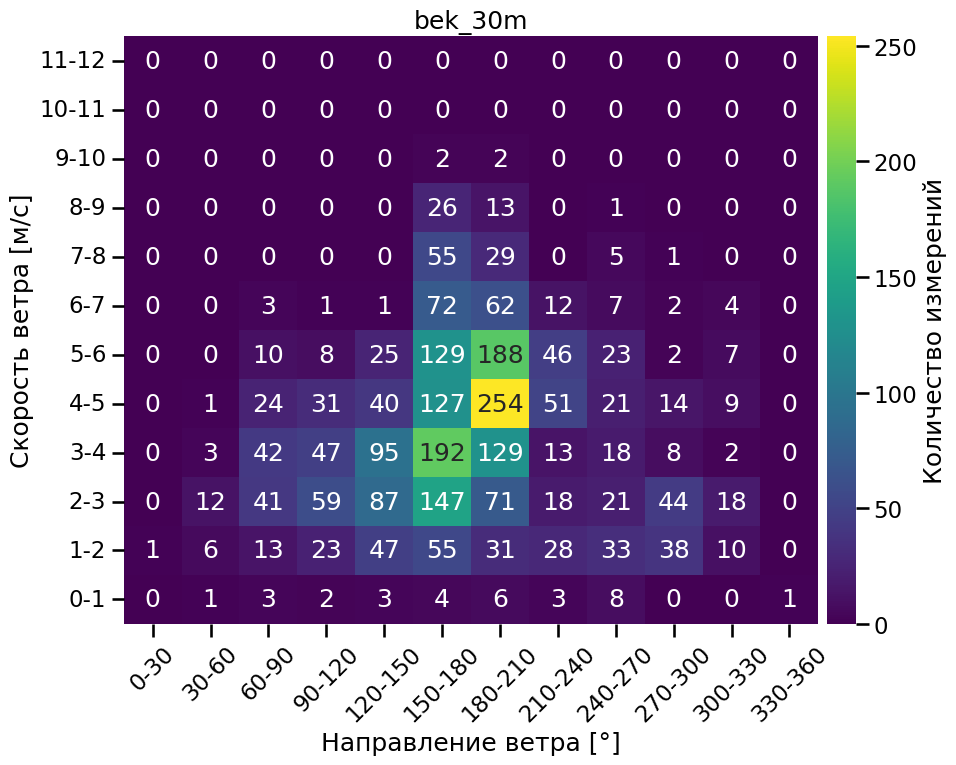

In [232]:
# Binning data
# speed_bins = np.arange(0, df.Vvec.max() + 1, 1)  # Bins of 1 m/s

speed_bins = np.arange(0, 13, 1)  # Bins of 1 m/s
direction_step = 30
direction_bins = np.arange(0, 361, direction_step)  # Bins of 20 degrees

# Bin labels
speed_labels = [f"{int(x)}-{int(x+1)}" for x in speed_bins[:-1]]
direction_labels = [f"{int(x)}-{int(x+direction_step)}" for x in direction_bins[:-1]]

# Add bin columns
df['Speed_Bin'] = pd.cut(df.Vvec, bins=speed_bins, labels=speed_labels, right=False)
df['Direction_Bin'] = pd.cut(df.D, bins=direction_bins, labels=direction_labels, right=False)

# Create a pivot table
heatmap_data = df.pivot_table(index='Speed_Bin', columns='Direction_Bin', aggfunc='size', fill_value=0)

# Reverse the row order to correct the "upside-down" effect
heatmap_data = heatmap_data.iloc[::-1]

# Plot the heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data,
    annot=True,  # Show values inside the cells
    fmt="d",
    cmap="viridis",  # Change to other colormaps like 'coolwarm', 'plasma', etc.
    cbar_kws={'label': 'Количество измерений', 'pad': 0.01}
)

# Customize plot
plt.title(name)
plt.xlabel('Направление ветра [°]')
plt.ylabel('Скорость ветра [м/с]')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Show plot
plt.show()


/var/folders/9b/mz6gplyd4gb2ks60mcv4xhw00000gn/T/ipykernel_50047/1498548566.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/Users/ilyadrozd/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning:

Covariance of the parameters could not be estimated

/Users/ilyadrozd/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

/Users/ilyadrozd/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning:

Covariance of the parameters could not be estimated

/Users/ilyadrozd/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning:

R^2 score is not well-defined with less than two 

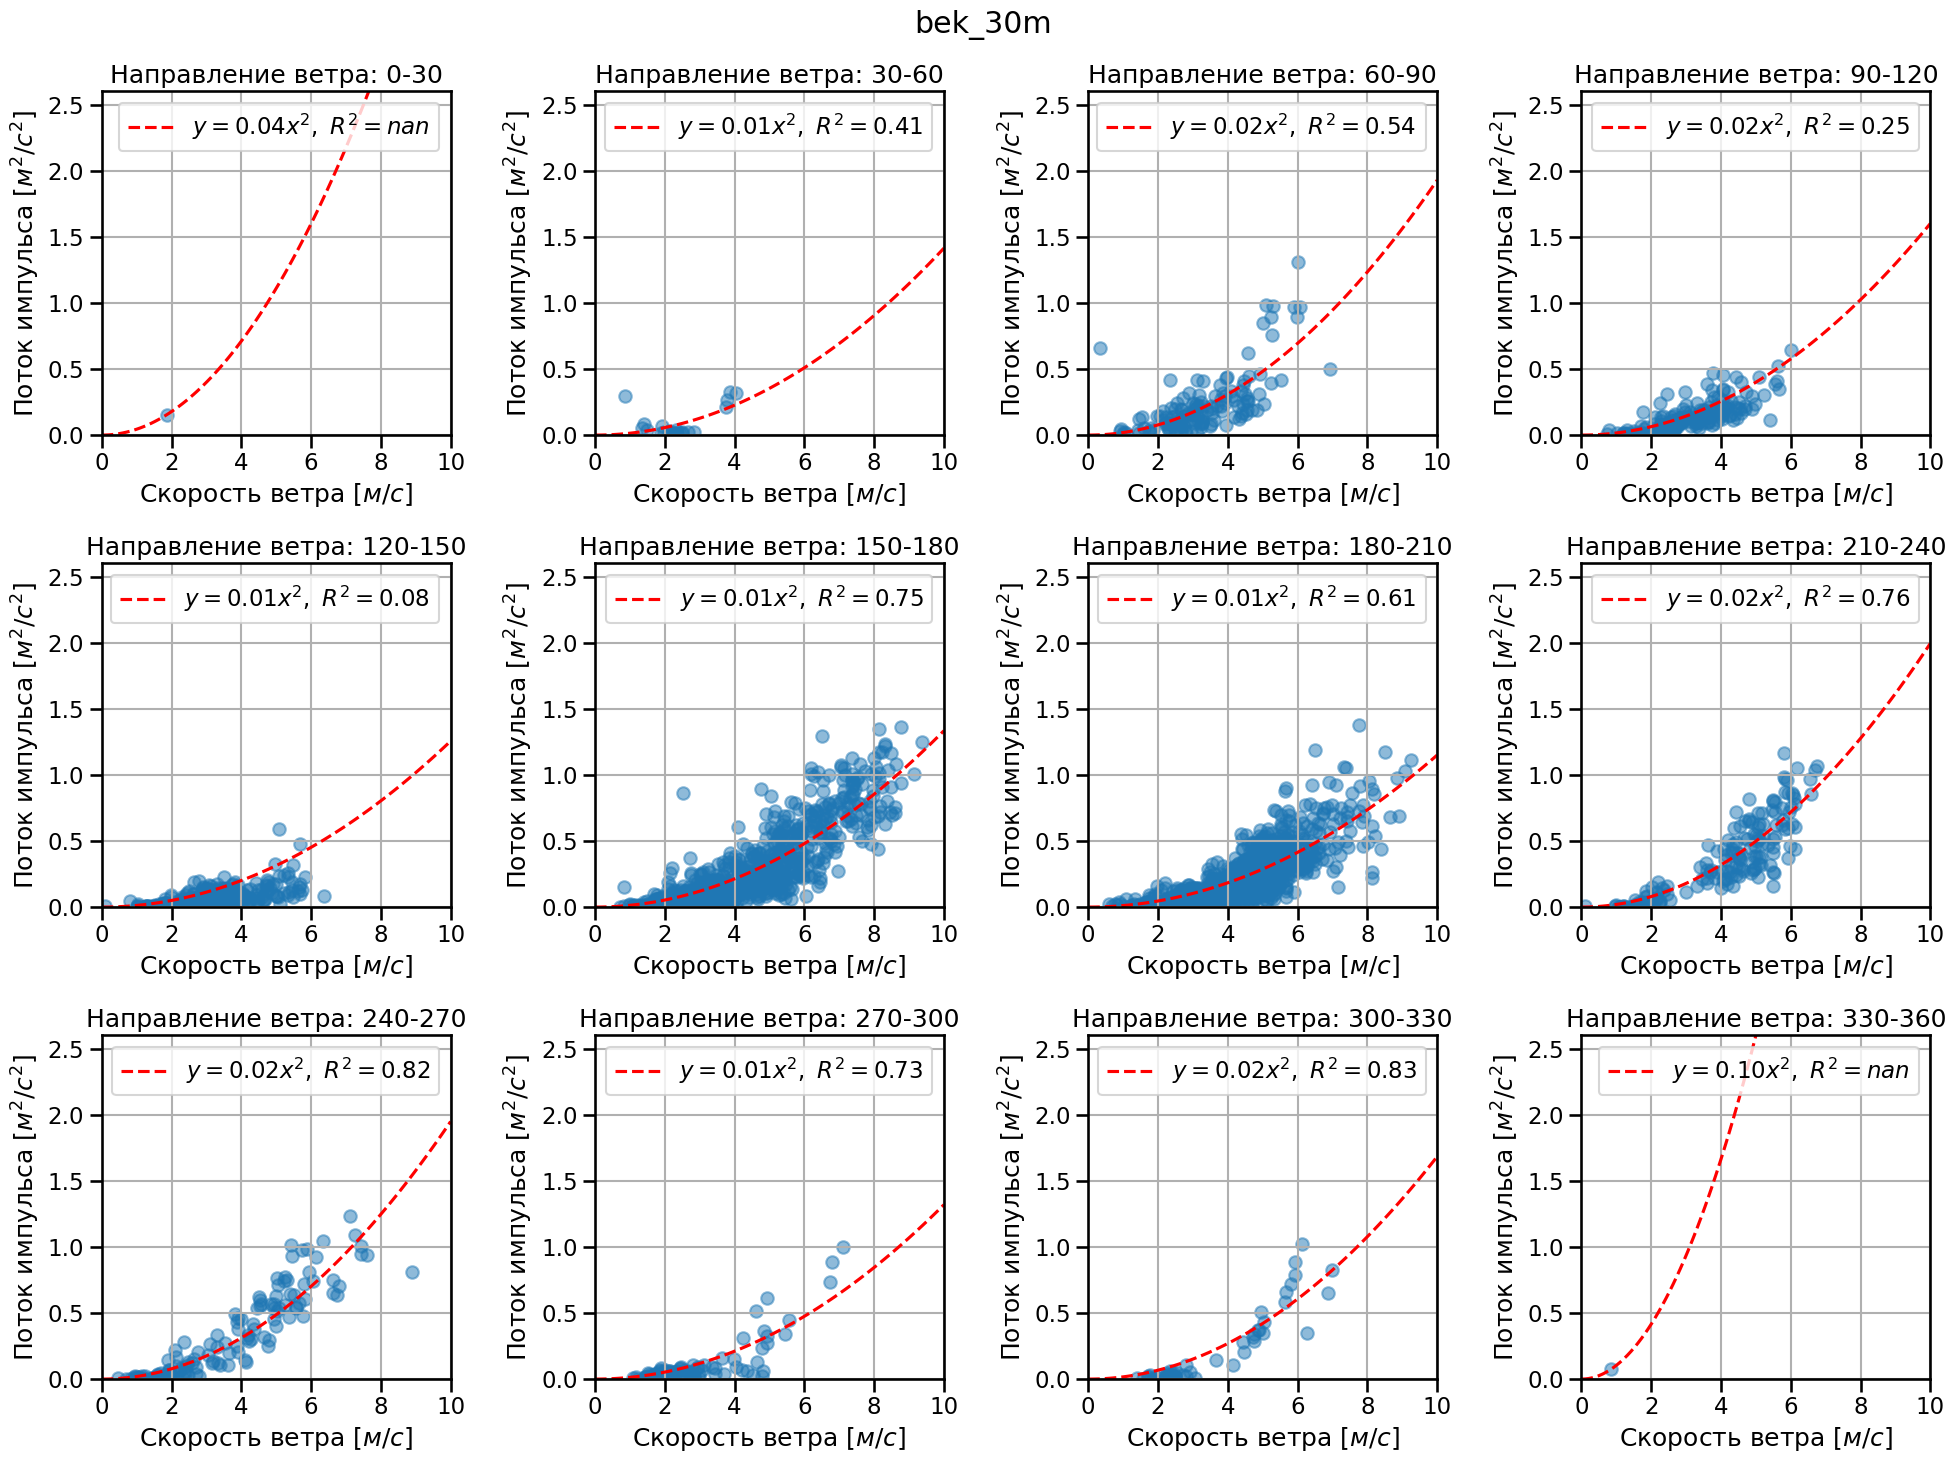

,Count,Average_wind_velocity,Slope_Coefficient
Direction_Bin,,,
0-30,1,1.860740,0.088771
30-60,23,2.393375,0.028271
60-90,136,3.308228,0.038553
90-120,171,3.157748,0.032012
120-150,298,3.192679,0.025113
150-180,809,4.360630,0.026677
180-210,785,4.584878,0.022990
210-240,171,4.048599,0.039902
240-270,137,3.538191,0.038959


In [233]:
# Define the parabola function
def parabola(x, A):
    return A * x**2

# Initialize a list to collect rows
results = []

# Group data by Direction_Bin
groups = df.groupby('Direction_Bin')

# Set up the figure and axes
num_bins = len(df['Direction_Bin'].cat.categories)
fig, axes = plt.subplots(
    nrows=num_bins // 4 + (num_bins % 4 > 0),  # Calculate rows to fit 4 plots per row
    ncols=4,  # 4 columns
    figsize=(20, num_bins * 5 / 4)  # Adjust size dynamically
)
fig.suptitle(name)
# Flatten axes array for easy iteration
axes = axes.flatten()

# Loop through each direction bin and corresponding axis
for i, (direction, group) in enumerate(groups):
    ax = axes[i]
    # Scatter plot
    ax.scatter(group['Vvec'], group['wu_h'], alpha=0.5)
    
    # Fit the parabola
    try:
        popt, _ = curve_fit(parabola, group['Vvec'], group['wu_h'])
        A = popt[0]  # Fitted slope coefficient

        # Calculate count of values in the bin
        count = group.shape[0]
        ws = group.Vvec.mean()

        # Append the results as a dictionary
        results.append({'Direction_Bin': direction, 'Count': count, 'Average_wind_velocity': ws, 'Slope_Coefficient': A*2})
        
        # Generate y values using the fitted parabola
        x_vals = np.linspace(0, 10, 100)
        y_vals = parabola(x_vals, A)

        y_pred = parabola(group['Vvec'], A)
        r2 = r2_score(group['wu_h'], y_pred)
        
        ax.plot(x_vals, y_vals, color='red', linestyle='--', label=f'$y = {A:.2f}x^2,$ $R^2={r2:.2f}$')
        
    except Exception as e:
        ax.text(0.5, 1.3, 'Fit failed', color='red', fontsize=10)
        results.append({'Direction_Bin': direction, 'Count': np.nan, 'Average_wind_velocity': np.nan, 'Slope_Coefficient': np.nan})
    
    # Customize plot
    ax.set_title(f'Направление ветра: {direction}')
    ax.set_xlabel('Скорость ветра [$м/с$]')
    ax.set_ylabel('Поток импульса [$м^2/с^2$]')
    ax.set_xlim([0, 10])
    ax.set_ylim([0, 2.6])
    ax.grid(True)
    ax.legend()

# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


# Create the DataFrame from the results list
result_df = pd.DataFrame(results).set_index('Direction_Bin')

result_df.to_csv(f'metadata_{name}.csv')
result_df

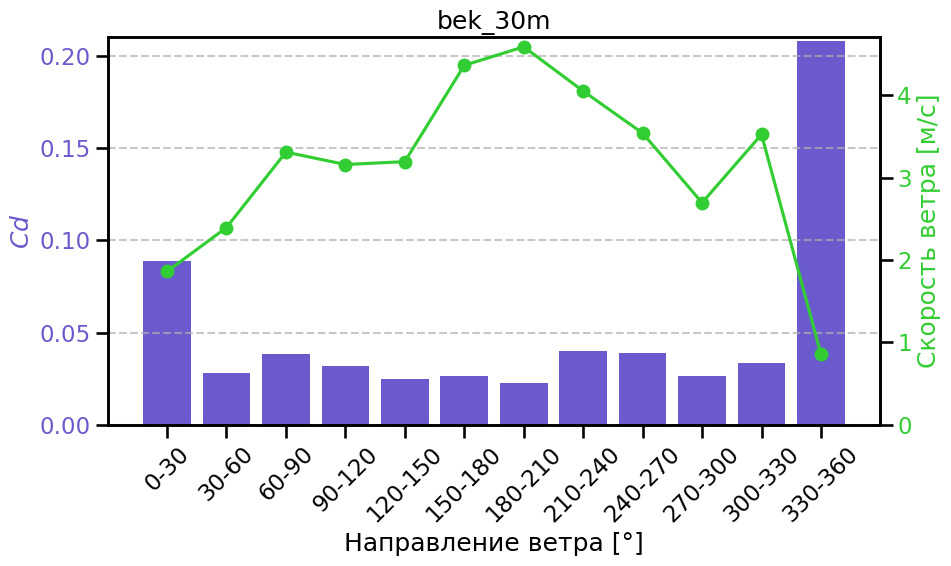

In [237]:
# Plotting the bar chart for Slope Coefficient with a second y-axis for Count
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for Slope Coefficient
ax1.bar(result_df.index, result_df['Slope_Coefficient'], color='slateblue', label='Slope Coefficient')
ax1.set_title(name)
ax1.set_ylim([0,0.21])
ax1.set_xlabel('Направление ветра [°]')
ax1.set_ylabel('$Cd$', color='slateblue')
ax1.tick_params(axis='y', labelcolor='slateblue')
ax1.set_xticks(range(len(result_df.index)))
ax1.set_xticklabels(result_df.index, rotation=45)

# Create a second y-axis for Count
ax2 = ax1.twinx()
ax2.set_ylim([0,4.7])
ax2.plot(result_df.index, result_df['Average_wind_velocity'], color='limegreen', marker='o', linestyle='-')
ax2.set_ylabel('Скорость ветра [м/с]', color='limegreen')
ax2.tick_params(axis='y', labelcolor='limegreen')

# Add grid and layout adjustment
ax1.grid(axis='y', linestyle='--', alpha=0.7)
fig.tight_layout()

# Show the plot
plt.show()


In [41]:
domain = [-1500,1500,-1500,1500] # Domain size as an array of [xmin xmax ymin ymax] [m].
dx = 3
lon_ul, lat_ul = new_point(tower_lat, tower_lon, domain[3], domain[0], xy=True)
lon_lr, lat_lr = new_point(tower_lat, tower_lon, domain[2], domain[1], xy=True)
crs = CRS.from_epsg(4326)  # 'EPSG:4326'

footprint = fpc.FFP_climatology(zm = list(df.z), 
                                z0 = None, 
                                umean = list(df.Vvec),
                                wind_dir = list(df.D), 
                                h = list(df.h_abl), 
                                ol = list(df.L), 
                                sigmav = list(df.std_u),
                                ustar = list(df.u_star), 
                                dx = dx, 
                                domain = domain,
                                rslayer = False,
                                smooth_data = False,
                                crop = False, 
                                verbosity = 2,
                                fig = False)

    
# Конвертирование наибольшего контура футпринта (обычно 80%) в координаты и сохранение в shp формате
coordinates = [new_point(tower_lat, tower_lon, y, x, xy=True) for y, x in zip(footprint['yr'][-1], footprint['xr'][-1])] # Преобразуем расстояние от мачты в координаты
polygon = Polygon(coordinates)  # Создание полигона с использованием координат
gdf = gpd.GeoDataFrame(geometry=[polygon])  # Создание геопандас GeoDataFrame с полигоном
gdf.crs = crs  # Установка системы координат
file_path = f"{output_path}{name}_clim_{int(footprint['rs'][-1]*100)}.shp"
gdf.to_file(file_path) # Сохранение GeoDataFrame в файле .shp

# Сохранение функции распределения футпринта в tif формате
data = footprint['fclim_2d'][::-1]
height, width = data.shape
transform = from_bounds(lon_ul, lat_lr, lon_lr, lat_ul, width, height) 
file_path = f"{output_path}{name}_clim_{domain[1]-domain[0]}x{domain[3]-domain[2]}m_{dx}m.tif"
with rasterio.open(file_path, 'w', driver='GTiff', height=height, width=width, count=1,
                   dtype=data.dtype, crs=crs, transform=transform, nodata=None) as dst:
    dst.write(data, 1)
    



Alert(0014):
 No valid z0 passed, using umean.
 Execution continues.

Calculating footprint  1  of  5928

Error(0007):
 zm/ol (measurement height to Obukhov length ratio) must be equal or larger than -15.5.
 Execution continues.

Error(0016):
 At least one required input is invalid. Skipping current footprint.
 Execution continues.
Calculating footprint  297  of  5928

Error(0007):
 zm/ol (measurement height to Obukhov length ratio) must be equal or larger than -15.5.
 Execution continues.

Error(0016):
 At least one required input is invalid. Skipping current footprint.
 Execution continues.

Error(0007):
 zm/ol (measurement height to Obukhov length ratio) must be equal or larger than -15.5.
 Execution continues.

Error(0016):
 At least one required input is invalid. Skipping current footprint.
 Execution continues.
Calculating footprint  593  of  5928
Calculating footprint  889  of  5928

Error(0007):
 zm/ol (measurement height to Obukhov length ratio) must be equal or larger than -

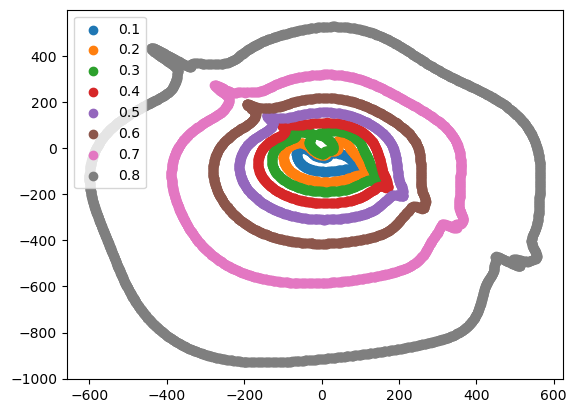

In [43]:
for xr, yr, rs in zip(footprint['xr'], footprint['yr'], footprint['rs']):
    plt.scatter(xr, yr, label = rs)
plt.legend()
